In [3]:
import os
import numpy as np
import pandas as pd
import math
from PIL import Image, ImageDraw
import yfinance as yf

# Define directories and image sizes based on the timeframe
image_dirs = {
    "5-day": "stock_images_5day",
    "20-day": "stock_images_20day",
    "60-day": "stock_images_60day",
}

for d in image_dirs.values():
    os.makedirs(d, exist_ok=True)

image_sizes = {"5-day": (15, 32), "20-day": (60, 64), "60-day": (180, 96)}

# Configuration parameters
class Config:
    BAR_WIDTH = 3
    IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}
    IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
    VOLUME_HEIGHT_RATIO = 0.2  # Volume bars take 20% of total image height
    VOLUME_CHART_GAP = 2
    BACKGROUND_COLOR = 255  # White background
    CHART_COLOR = 0  # Black for price bars
    VOLUME_COLOR = 128  # Gray for volume bars

config = Config()

# **OHLC Chart Drawing Class**
# **OHLC Chart Drawing Class (Fixed Volume Bars)**
# **OHLC Chart Drawing Class (Volume Bars Start from the Image Bottom)**
class DrawOHLC:
    def __init__(self, df, time_frame, has_volume_bar=True, has_moving_average=True):
        self.df = df.copy()
        self.ohlc_len = len(df)
        self.time_frame = time_frame
        self.has_volume_bar = has_volume_bar
        self.has_moving_average = has_moving_average
        assert self.ohlc_len in [5, 20, 60]  # Ensure correct rolling window

        # Image dimensions
        self.ohlc_width = config.IMAGE_WIDTH[time_frame]
        self.ohlc_height = config.IMAGE_HEIGHT[time_frame]
        self.volume_height = int(self.ohlc_height * config.VOLUME_HEIGHT_RATIO) if self.has_volume_bar else 0

        self.minp = df[['Open', 'High', 'Low', 'Close']].min().min()
        self.maxp = df[['Open', 'High', 'Low', 'Close']].max().max()
        self.max_volume = df["Volume"].max() if self.has_volume_bar else None

        # **Fix: Compute Moving Average & Drop NaN**
        if self.has_moving_average:
            self.df["MA"] = self.df["Close"].rolling(window=self.ohlc_len, min_periods=1).mean()
            self.df["MA"] = self.df["MA"].bfill()  # Fill forward missing values
            #print(f"📊 Sample MA values for {time_frame}: {self.df['MA'].tail(5).tolist()}")

        first_center = (config.BAR_WIDTH - 1) / 2.0
        self.centers = np.arange(
            first_center,
            first_center + config.BAR_WIDTH * self.ohlc_len,
            config.BAR_WIDTH,
            dtype=int
        )

    def __ret_to_yaxis(self, val):
        """Convert price values to y-axis pixel positions."""
        pixels_per_unit = (self.ohlc_height - 1.0) / (self.maxp - self.minp)
        return int(np.around((val - self.minp) * pixels_per_unit))

    def __ret_to_yaxis_volume(self, val):
        """Convert volume values to correctly scaled y-axis positions (bottom-up)."""
        if self.max_volume is None or self.max_volume == 0:
            return 0
        return int((val / self.max_volume) * self.volume_height)

    def draw_image(self):
        """Draws OHLC candlestick chart along with correctly positioned volume bars and MA line."""
        total_height = self.ohlc_height + self.volume_height + (config.VOLUME_CHART_GAP if self.has_volume_bar else 0)

        # **Fix: Set background to BLACK (0) and candlestick to WHITE (255)**
        image = Image.new("L", (self.ohlc_width, total_height), config.CHART_COLOR)  # Background is BLACK
        draw = ImageDraw.Draw(image)

        # **Step 1: Draw OHLC chart (Price Movements)**
        for day in range(self.ohlc_len):
            highp, lowp, closep, openp = self.df.iloc[day][['High', 'Low', 'Close', 'Open']]
            if np.isnan(highp) or np.isnan(lowp):
                continue

            high_pixel = self.__ret_to_yaxis(highp)
            low_pixel = self.__ret_to_yaxis(lowp)
            open_pixel = self.__ret_to_yaxis(openp)
            close_pixel = self.__ret_to_yaxis(closep)

            draw.line([self.centers[day], high_pixel, self.centers[day], low_pixel], fill=255)
            draw.line([self.centers[day] - 1, open_pixel, self.centers[day], open_pixel], fill=255)
            draw.line([self.centers[day], close_pixel, self.centers[day] + 1, close_pixel], fill=255)

        # **Step 2: Draw Volume Bars**
        if self.has_volume_bar:
            volume_bottom = total_height - 1
            volume_top_limit = volume_bottom - self.volume_height

            for day in range(self.ohlc_len):
                volume = self.df.iloc[day]["Volume"]
                if np.isnan(volume):
                    continue

                volume_pixel = self.__ret_to_yaxis_volume(volume)
                volume_top = volume_bottom - volume_pixel
                draw.line([self.centers[day], volume_bottom, self.centers[day], volume_top], fill=255)

        # **Step 3: Draw Moving Average Line**
        if self.has_moving_average and "MA" in self.df.columns:
            for day in range(self.ohlc_len - 1):
                if np.isnan(self.df["MA"].iloc[day]) or np.isnan(self.df["MA"].iloc[day + 1]):
                    continue
                ma_start = self.__ret_to_yaxis(self.df["MA"].iloc[day])
                ma_end = self.__ret_to_yaxis(self.df["MA"].iloc[day + 1])

                # **Fix: Check if within valid range before drawing**
                if ma_start >= 0 and ma_end >= 0:
                    draw.line([self.centers[day], ma_start, self.centers[day + 1], ma_end], fill=255)

        return image

        # **Step 2: Draw Volume Bars at the Bottom of the Image (White)**
        if self.has_volume_bar:
            volume_bottom = total_height - 1  # Start at the **bottom of the image**
            volume_top_limit = volume_bottom - self.volume_height  # Maximum height volume bars can reach

            for day in range(self.ohlc_len):
                volume = self.df.iloc[day]["Volume"]
                if np.isnan(volume):
                    continue

                volume_pixel = self.__ret_to_yaxis_volume(volume)
                volume_top = volume_bottom - volume_pixel  # **Fix: Adjust so bars grow from the bottom**

                # **Fix: Draw volume bars in WHITE**
                draw.line([self.centers[day], volume_bottom, self.centers[day], volume_top], fill=255)

        # **Step 3: Draw Moving Average Line (White)**
        if self.has_moving_average and "MA" in self.df.columns:
            for day in range(self.ohlc_len - 1):
                if np.isnan(self.df["MA"].iloc[day]) or np.isnan(self.df["MA"].iloc[day + 1]):
                    continue
                ma_start = self.__ret_to_yaxis(self.df["MA"].iloc[day])
                ma_end = self.__ret_to_yaxis(self.df["MA"].iloc[day + 1])

                # **Fix: Draw moving average line in WHITE (255)**
                draw.line([self.centers[day], ma_start, self.centers[day + 1], ma_end], fill=255)

        return image

def fetch_and_clean_stock_data(stock_list, start_date="2015-01-01", end_date="2024-01-01"):
    all_data = {}
    for stock in stock_list:
        print(f"📥 Fetching data for {stock}...")
        data = yf.download(stock, start=start_date, end=end_date)
        data.to_csv(f"{stock}_yfinance_data.csv", index=False)

        # Reset index to make 'Date' a column
        data.reset_index(inplace=True)

        # Check the number of columns dynamically
        expected_cols = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
        available_cols = data.columns.tolist()

        if len(available_cols) == 7:
            data.columns = expected_cols
            data.drop(columns=["Adj Close"], inplace=True)  # Remove unnecessary column
        elif len(available_cols) == 6:
            data.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]  # Standard columns
        else:
            raise ValueError(f"Unexpected column count: {len(available_cols)}")

        # Convert Date to datetime
        data["Date"] = pd.to_datetime(data["Date"])

        # Ensure numeric values
        for col in ["Open", "High", "Low", "Close", "Volume"]:
            data[col] = pd.to_numeric(data[col], errors="coerce")

        data["Future_5day_Close"] = data["Close"].shift(-5)  # Adjust for prediction
        data["Future_20day_Close"] = data["Close"].shift(-20)
        data["Future_60day_Close"] = data["Close"].shift(-60)

        data["Label_5day"] = (data["Future_5day_Close"] > data["Close"]).astype(int)
        data["Label_20day"] = (data["Future_20day_Close"] > data["Close"]).astype(int)
        data["Label_60day"] = (data["Future_60day_Close"] > data["Close"]).astype(int)

        # Drop NaN values
        data.dropna(inplace=True)

        # Save cleaned CSV
        data.to_csv(f"{stock}_cleaned_data.csv", index=False)
        all_data[stock] = data

    print("✅ Stock data cleaned and saved!")
    return all_data

# **Updated Image Generation Function**
def generate_stock_images(stock_data, step_size=1):
    image_dirs = {
        "5-day": "stock_images_5day",
        "20-day": "stock_images_20day",
        "60-day": "stock_images_60day",
    }

    for d in image_dirs.values():
        os.makedirs(d, exist_ok=True)

    for stock, df in stock_data.items():
        print(f"📊 Generating OHLC images for {stock}...")

        for time_frame, window_size in {"5-day": 5, "20-day": 20, "60-day": 60}.items():
            img_dir = image_dirs[time_frame]

            for i in range(0, len(df) - window_size, step_size):
                window = df.iloc[i : i + window_size]

                # Create a DrawOHLC object and generate chart
                chart = DrawOHLC(window, time_frame=int(time_frame.split("-")[0]))
                image = chart.draw_image()

                if image:
                    save_path = os.path.join(img_dir, f"{stock}_{i}.png")
                    image.save(save_path)

            print(f"✅ {len(df) - window_size} images generated for {stock} ({time_frame})")

# **Run Image Generation**
stocks = ["AAPL", "GOOGL", "AMZN"]

stock_data = fetch_and_clean_stock_data(stocks)
generate_stock_images(stock_data)

📥 Fetching data for AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

📥 Fetching data for GOOGL...


📥 Fetching data for AMZN...


[*********************100%***********************]  1 of 1 completed


✅ Stock data cleaned and saved!
📊 Generating OHLC images for AAPL...
✅ 2199 images generated for AAPL (5-day)
✅ 2184 images generated for AAPL (20-day)
✅ 2144 images generated for AAPL (60-day)
📊 Generating OHLC images for GOOGL...
✅ 2199 images generated for GOOGL (5-day)
✅ 2184 images generated for GOOGL (20-day)
✅ 2144 images generated for GOOGL (60-day)
📊 Generating OHLC images for AMZN...
✅ 2199 images generated for AMZN (5-day)
✅ 2184 images generated for AMZN (20-day)
✅ 2144 images generated for AMZN (60-day)


In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # ✅ FIXED IMPORT
from tensorflow.keras.utils import to_categorical

# Define image directories for different timeframes
image_dirs = {
    "5-day": "stock_images_5day",
    "20-day": "stock_images_20day",
    "60-day": "stock_images_60day",
}

# ✅ Define correct input shapes (H, W, 1) as per the paper
input_shapes = {
    "5-day": (32, 15, 1),
    "20-day": (64, 60, 1),
    "60-day": (96, 180, 1),
}

# ✅ Function to load OHLC images and labels with time-based splitting
def load_images_and_labels(stock_data, image_dirs):
    image_data, labels_data = {"5-day": [], "20-day": [], "60-day": []}, {"5-day": [], "20-day": [], "60-day": []}
    date_indices = {"5-day": [], "20-day": [], "60-day": []}  # Store dates for time-based split

    for stock, df in stock_data.items():
        df = df.sort_values(by="Date")  # Ensure chronological order
        for time_frame, img_dir in image_dirs.items():
            window_size = int(time_frame.split("-")[0])

            for i in range(len(df) - window_size):
                img_path = os.path.join(img_dir, f"{stock}_{i}.png")
                
                if os.path.exists(img_path):
                    # ✅ Load image in grayscale and resize
                    img = load_img(img_path, color_mode="grayscale",
                                   target_size=(input_shapes[time_frame][0], input_shapes[time_frame][1]))
                    img_array = img_to_array(img) / 255.0  # Normalize (0 to 1)

                    # ✅ Ensure image shape is (H, W, 1)
                    img_array = np.expand_dims(np.squeeze(img_array), axis=-1)

                    # Append image and corresponding labels
                    if all(label in df.columns for label in ["Label_5day", "Label_20day", "Label_60day"]):
                        image_data[time_frame].append(img_array)
                        labels_data[time_frame].append(df.iloc[i][f"Label_{time_frame.split('-')[0]}day"])
                        date_indices[time_frame].append(df.iloc[i]["Date"])  # Store the corresponding date

    # Convert lists to NumPy arrays
    for time_frame in image_data.keys():
        image_data[time_frame] = np.array(image_data[time_frame])
        labels_data[time_frame] = np.array(labels_data[time_frame])
        labels_data[time_frame] = to_categorical(labels_data[time_frame], num_classes=2).astype(np.float32)

    return image_data, labels_data, date_indices  # ✅ Return date indices for time-based splitting

# ✅ Load images, labels, and corresponding dates
image_data, labels_data, date_indices = load_images_and_labels(stock_data, image_dirs)

# ✅ Function to perform time-based data splitting
def time_based_split(images, labels, dates, train_ratio=0.6, val_ratio=0.2):
    """
    Splits dataset chronologically into Train, Validation, and Test sets.
    - 60% Training
    - 20% Validation
    - 20% Testing
    """
    sorted_indices = np.argsort(dates)  # Sort by date
    total_samples = len(sorted_indices)

    train_end = int(train_ratio * total_samples)
    val_end = int((train_ratio + val_ratio) * total_samples)

    train_idx = sorted_indices[:train_end]
    val_idx = sorted_indices[train_end:val_end]
    test_idx = sorted_indices[val_end:]

    return images[train_idx], images[val_idx], images[test_idx], labels[train_idx], labels[val_idx], labels[test_idx]

# ✅ Apply time-based split for each timeframe
X_train, X_val, X_test, y_train, y_val, y_test = {}, {}, {}, {}, {}, {}

for time_frame in ["5-day", "20-day", "60-day"]:
    X_train[time_frame], X_val[time_frame], X_test[time_frame], \
    y_train[time_frame], y_val[time_frame], y_test[time_frame] = time_based_split(
        image_data[time_frame], labels_data[time_frame], np.array(date_indices[time_frame])
    )

# ✅ Print dataset shapes
for time_frame in ["5-day", "20-day", "60-day"]:
    print(f"✅ {time_frame}: Train {X_train[time_frame].shape}, Val {X_val[time_frame].shape}, Test {X_test[time_frame].shape}")


✅ 5-day: Train (3958, 32, 15, 1), Val (1319, 32, 15, 1), Test (1320, 32, 15, 1)
✅ 20-day: Train (3931, 64, 60, 1), Val (1310, 64, 60, 1), Test (1311, 64, 60, 1)
✅ 60-day: Train (3859, 96, 180, 1), Val (1286, 96, 180, 1), Test (1287, 96, 180, 1)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
)
from tensorflow.keras.optimizers import Adam

# ✅ Set which models to include
ENABLE_5_DAY = True
ENABLE_20_DAY = False  # Set to True to enable 20-day model
ENABLE_60_DAY = False  # Set to True to enable 60-day model

# Define CNN models for each timeframe
def build_cnn_model(input_shape, conv_layers, fc_units, dropout_rate=0.5, learning_rate=0.0001):
    """
    Builds a CNN model based on the architecture from the paper with correct stride and dilation.
    
    Args:
        input_shape (tuple): Shape of input images (H, W, C).
        conv_layers (list): List of filter sizes for convolutional layers.
        fc_units (int): Number of units in the fully connected layer.
        dropout_rate (float): Dropout rate for regularization.
        learning_rate (float): Learning rate for the optimizer.
    
    Returns:
        model (tf.keras.Model): The constructed CNN model.
    """
    inputs = Input(shape=input_shape)

    x = inputs
    for i, filters in enumerate(conv_layers):
        # ✅ Fix: Use strides (1,3) in the first layer, but no dilation
        x = Conv2D(
            filters=filters, 
            kernel_size=(5, 3), 
            strides=(1, 3) if i == 0 else (1, 1),  # ✅ First layer: Stride (1,3), Others: (1,1)
            dilation_rate=(1, 1),  # ✅ Fix: No dilation (to avoid conflict with stride)
            padding="same", 
            kernel_initializer="glorot_uniform"  # Xavier Initialization
        )(x)

        # Batch normalization
        x = BatchNormalization()(x)

        # Leaky ReLU activation
        x = LeakyReLU(alpha=0.1)(x)

        # Max-pooling layer (2x1)
        x = MaxPooling2D(pool_size=(2, 1), strides=(2, 1))(x)

    # Flatten the output before fully connected layers
    x = Flatten()(x)

    # Fully connected layer
    x = Dense(units=fc_units, activation="relu")(x)
    x = Dropout(rate=dropout_rate)(x)  # Dropout for regularization

    # Output layer with softmax activation for binary classification
    outputs = Dense(units=2, activation="softmax")(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model

# ✅ Define input shapes and architecture for each timeframe
cnn_architecture = {}
if ENABLE_5_DAY:
    cnn_architecture["5-day"] = {"input_shape": (32, 15, 1), "conv_layers": [64, 128], "fc_units": 15360}
if ENABLE_20_DAY:
    cnn_architecture["20-day"] = {"input_shape": (64, 60, 1), "conv_layers": [64, 128, 256], "fc_units": 46080}
if ENABLE_60_DAY:
    cnn_architecture["60-day"] = {"input_shape": (96, 180, 1), "conv_layers": [64, 128, 256, 512], "fc_units": 184320}

# ✅ Build models for the enabled timeframes
models = {}
for time_frame, params in cnn_architecture.items():
    print(f"🔵 Creating CNN model for {time_frame}...")
    models[time_frame] = build_cnn_model(
        input_shape=params["input_shape"], 
        conv_layers=params["conv_layers"], 
        fc_units=params["fc_units"]
    )

# ✅ Print model summaries for the enabled models
for time_frame, model in models.items():
    print(f"✅ {time_frame} Model Summary:")
    model.summary()


🔵 Creating CNN model for 5-day...


C:\Users\dhair\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


✅ 5-day Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 15, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 5, 64)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 5, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 5, 128)     │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 5, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15360)          │    78,658,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        30,722 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,814,082 (300.65 MB)

 Trainable params: 78,813,698 (300.65 MB)

 Non-trainable params: 384 (1.50 KB)

🔵 Training the 5-day model...
Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 72s 526ms/step - accuracy: 0.8648 - loss: 0.5915 - val_accuracy: 0.6975 - val_loss: 0.5913
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 64s 516ms/step - accuracy: 0.8845 - loss: 0.3932 - val_accuracy: 0.6558 - val_loss: 0.5596
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 64s 513ms/step - accuracy: 0.8996 - loss: 0.3269 - val_accuracy: 0.8688 - val_loss: 0.3218
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 64s 514ms/step - accuracy: 0.9254 - loss: 0.2307 - val_accuracy: 0.8870 - val_loss: 0.2711
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 64s 514ms/step - accuracy: 0.9442 - loss: 0.1557 - val_accuracy: 0.8688 - val_loss: 0.5181
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 64s 518ms/step - accuracy: 0.9285 - loss: 0.1856 - val_accuracy: 0.9067 - val_loss: 0.3104
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 510ms/step - accuracy: 0.9585 - loss: 0.1060 - val_accuracy: 0.8855 - val_loss: 0.5730
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 510ms/ste

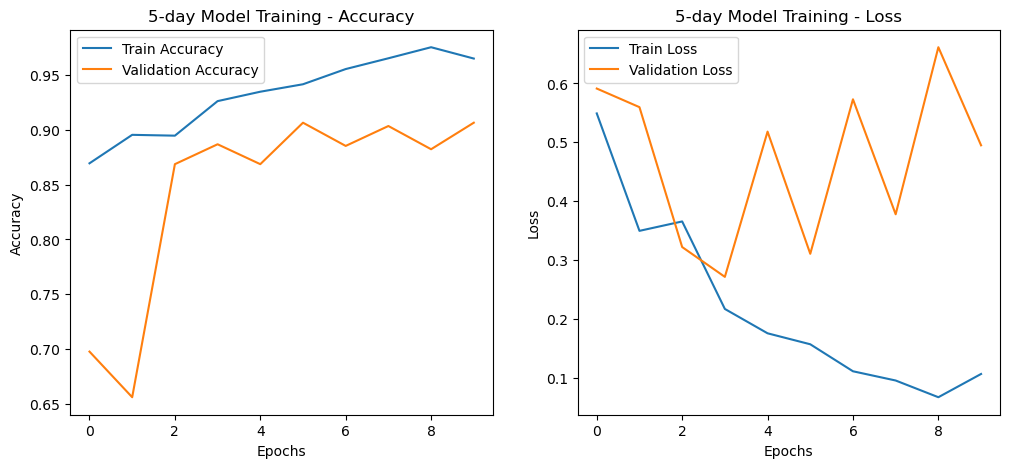


🔵 Generating predictions...
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step

🔹 Sample Predictions vs. True Labels:
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0

🔵 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       668
           1       0.87      0.93      0.90       652

    accuracy                           0.90      1320
   macro avg       0.90      0.90      0.90      1320
weighted avg       0.90      0.90      0.90      1320


🔵 Plotting Confusion Matrix...


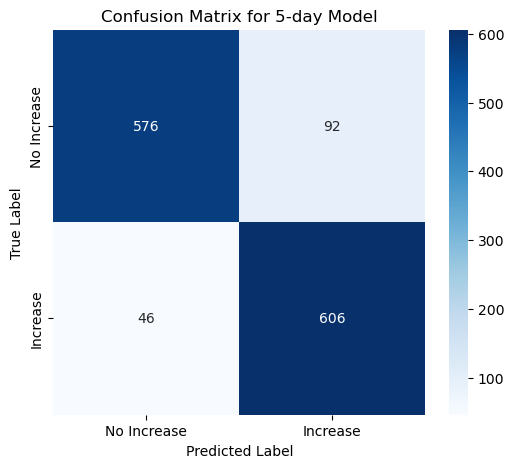

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Define Training Parameters
BATCH_SIZE = 32  # Adjust if needed
EPOCHS = 10  # Increase for better accuracy

print("🔵 Training the 5-day model...")

# ✅ Train the 5-day model with explicit validation set
history_5day = models["5-day"].fit(
    X_train["5-day"], 
    y_train["5-day"], 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(X_val["5-day"], y_val["5-day"]),  # ✅ Use explicit validation set
    verbose=1
)

print("\n🔵 Evaluating on the test set...")

# ✅ Evaluate on test set
test_loss, test_acc = models["5-day"].evaluate(X_test["5-day"], y_test["5-day"], verbose=1)

print(f"\n✅ 5-day Model - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# ✅ Function to Plot Training History
def plot_training_history(history, title="Model Training"):
    plt.figure(figsize=(12, 5))

    # ✅ Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    # ✅ Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.show()

# ✅ Plot training history
plot_training_history(history_5day, title="5-day Model Training")

print("\n🔵 Generating predictions...")

# ✅ Get model predictions
y_pred = models["5-day"].predict(X_test["5-day"])

# ✅ Convert predictions to binary labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test["5-day"], axis=1)

# ✅ Print sample predictions
print("\n🔹 Sample Predictions vs. True Labels:")
for i in range(10):
    print(f"Predicted: {y_pred_labels[i]}, Actual: {y_true_labels[i]}")

print("\n🔵 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

print("\n🔵 Plotting Confusion Matrix...")

# ✅ Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Increase", "Increase"], yticklabels=["No Increase", "Increase"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 5-day Model")
plt.show()


In [7]:
import numpy as np
import pandas as pd

# ✅ Step 1: Get CNN Predictions (Probability of Increase)
y_pred_probs = models["5-day"].predict(X_test["5-day"])[:, 1]  # Probability of stock price increase
y_true_returns = y_test["5-day"][:, 1]  # Actual next-period return (1 = increase, 0 = decrease)

# ✅ Step 2: Create a DataFrame with Predicted Probabilities & Actual Returns
portfolio_df = pd.DataFrame({"Predicted_Prob": y_pred_probs, "Actual_Return": y_true_returns})

# ✅ Step 3: Ensure No NaNs in Data
portfolio_df = portfolio_df.dropna()

# ✅ Step 4: Sort Stocks into Deciles Based on CNN Probabilities
portfolio_df["Decile"] = pd.qcut(portfolio_df["Predicted_Prob"], q=10, labels=False, duplicates="drop")

# ✅ Step 5: Define High (H) and Low (L) Portfolios
high_portfolio = portfolio_df[portfolio_df["Decile"] == portfolio_df["Decile"].max()]["Actual_Return"]
low_portfolio = portfolio_df[portfolio_df["Decile"] == portfolio_df["Decile"].min()]["Actual_Return"]

# ✅ Step 6: Debugging Checks
print("\n🔹 High Portfolio Unique Returns:", high_portfolio.unique())
print("🔹 Low Portfolio Unique Returns:", low_portfolio.unique())

if high_portfolio.nunique() == 1:
    print("⚠ Warning: High portfolio has only one unique return value.")
if low_portfolio.nunique() == 1:
    print("⚠ Warning: Low portfolio has only one unique return value.")

# ✅ Step 7: Compute H-L Portfolio Returns (Only if portfolios are non-empty)
if high_portfolio.empty or low_portfolio.empty:
    print("⚠ Warning: High or Low Portfolio is empty. Cannot compute return.")
    hl_portfolio_returns = 0
    hl_sharpe_ratio = 0
else:
    hl_portfolio_returns = high_portfolio.mean() - low_portfolio.mean()

    # ✅ Step 8: Compute Sharpe Ratio (Handling Zero Standard Deviation)
    hl_portfolio_std = np.std(high_portfolio - low_portfolio)

    if hl_portfolio_std == 0 or np.isnan(hl_portfolio_std):
        print("⚠ Warning: Standard deviation is zero. Assigning Sharpe Ratio = 0.")
        hl_sharpe_ratio = 0
    else:
        hl_sharpe_ratio = hl_portfolio_returns / hl_portfolio_std * np.sqrt(252)  # 252 trading days

# ✅ Print Results
print(f"\n✅ High Portfolio Mean Return: {high_portfolio.mean() if not high_portfolio.empty else 0:.4f}")
print(f"✅ Low Portfolio Mean Return: {low_portfolio.mean() if not low_portfolio.empty else 0:.4f}")
print(f"✅ H-L Portfolio Return: {hl_portfolio_returns:.4f}")
print(f"✅ H-L Sharpe Ratio: {hl_sharpe_ratio:.4f}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

🔹 High Portfolio Unique Returns: [1. 0.]
🔹 Low Portfolio Unique Returns: [0. 1.]
⚠ Warning: Standard deviation is zero. Assigning Sharpe Ratio = 0.

✅ High Portfolio Mean Return: 0.9899
✅ Low Portfolio Mean Return: 0.0076
✅ H-L Portfolio Return: 0.9823
✅ H-L Sharpe Ratio: 0.0000


In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# ✅ Step 1: Convert Image Data to Numerical Features for RF & LR
def extract_features(stock_data, time_frame):
    """
    Extracts numerical features from OHLC data for Random Forest & Logistic Regression.
    """
    feature_list, label_list = [], []

    for stock, df in stock_data.items():
        window_size = int(time_frame.split("-")[0])  # Get rolling window size

        for i in range(len(df) - window_size):
            # Extract statistical features (mean, std, min, max)
            window = df.iloc[i:i + window_size]
            features = [
                window["Open"].mean(), window["High"].mean(), window["Low"].mean(), window["Close"].mean(),
                window["Open"].std(), window["High"].std(), window["Low"].std(), window["Close"].std(),
                window["Open"].min(), window["High"].min(), window["Low"].min(), window["Close"].min(),
                window["Open"].max(), window["High"].max(), window["Low"].max(), window["Close"].max(),
            ]

            # Get corresponding label
            label = df.iloc[i + window_size - 1][f"Label_{time_frame.split('-')[0]}day"]

            feature_list.append(features)
            label_list.append(label)

    return np.array(feature_list), np.array(label_list)

# ✅ Extract features & labels for 5-day model
X_features, y_labels = extract_features(stock_data, "5-day")

# ✅ Split Data into Train/Test Sets (Same as CNN)
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_features, y_labels, test_size=0.3, random_state=42)

# ✅ Normalize features
scaler = StandardScaler()
X_train_feat = scaler.fit_transform(X_train_feat)
X_test_feat = scaler.transform(X_test_feat)

# ✅ Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_feat, y_train_feat)

# ✅ Train Logistic Regression Classifier
lr_model = LogisticRegression()
lr_model.fit(X_train_feat, y_train_feat)

# ✅ Make Predictions
y_pred_rf = rf_model.predict(X_test_feat)
y_pred_lr = lr_model.predict(X_test_feat)

# ✅ Compute Accuracy Scores
rf_acc = accuracy_score(y_test_feat, y_pred_rf)
lr_acc = accuracy_score(y_test_feat, y_pred_lr)

# ✅ Evaluate CNN on Test Set
cnn_test_loss, cnn_test_acc = models["5-day"].evaluate(X_test["5-day"], y_test["5-day"], verbose=0)

# ✅ Print Final Comparison Table
print("\n🔹 Model Performance Comparison:")
print(f"✅ CNN Accuracy: {cnn_test_acc:.4f}")
print(f"✅ Random Forest Accuracy: {rf_acc:.4f}")
print(f"✅ Logistic Regression Accuracy: {lr_acc:.4f}")

# ✅ Print Classification Reports
print("\n🔹 Random Forest Classification Report:")
print(classification_report(y_test_feat, y_pred_rf))

print("\n🔹 Logistic Regression Classification Report:")
print(classification_report(y_test_feat, y_pred_lr))

# ✅ Conclusion
if cnn_test_acc > rf_acc and cnn_test_acc > lr_acc:
    print("\n🚀 CNN OUTPERFORMS Traditional Models! ✅")
else:
    print("\n⚠ CNN DOES NOT Outperform Traditional Models ❌ - Need Further Tuning!")



🔹 Model Performance Comparison:
✅ CNN Accuracy: 0.8955
✅ Random Forest Accuracy: 0.6641
✅ Logistic Regression Accuracy: 0.5848

🔹 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.55      0.58       820
           1       0.70      0.74      0.72      1160

    accuracy                           0.66      1980
   macro avg       0.65      0.65      0.65      1980
weighted avg       0.66      0.66      0.66      1980


🔹 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25       820
           1       0.60      0.88      0.71      1160

    accuracy                           0.58      1980
   macro avg       0.55      0.52      0.48      1980
weighted avg       0.56      0.58      0.52      1980


🚀 CNN OUTPERFORMS Traditional Models! ✅
